In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Bước 1: Định nghĩa Autoformer đơn giản

In [ ]:
class SimpleAutoformer(nn.Module):
    def __init__(self, input_dim=1, embed_dim=8, num_layers=1, nhead=2):
        super(SimpleAutoformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=64)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embed_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch, embed_dim)
        encoded = self.encoder(x)  # (seq_len, batch, embed_dim)
        encoded = encoded.permute(1, 0, 2)  # (batch, seq_len, embed_dim)
        out = self.output_layer(encoded)  # (batch, seq_len, 1)
        return out, encoded

In [ ]:
# Tạo dữ liệu chuỗi thời gian
def generate_multi_mode_data(n_samples=200, seq_len=24, n_modes=3):
    np.random.seed(42)
    A = np.random.randn(n_modes, 1) * 2.5
    modes = np.random.choice(n_modes, size=n_samples)
    data = []
    for m in modes:
        x = np.random.randn(seq_len, 1)
        y = A[m] * x + np.random.randn(seq_len, 1) * 0.1
        data.append(y)
    return torch.tensor(np.array(data), dtype=torch.float32), modes

In [ ]:
X_seq, true_modes = generate_multi_mode_data()

In [ ]:
# Mục tiêu: trung bình toàn bộ chuỗi (broadcast theo chiều thời gian)
y_seq = X_seq.mean(dim=1, keepdim=True).repeat(1, seq_len, 1)

In [ ]:
# ====== Khởi tạo và huấn luyện mô hình ======
model = SimpleAutoformer(input_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(10):
    optimizer.zero_grad()
    out, _ = model(X_seq)
    loss = criterion(out, y_seq)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/10 - Loss: {loss.item():.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 - Loss: 0.2013
Epoch 2/10 - Loss: 0.0858
Epoch 3/10 - Loss: 0.1009
Epoch 4/10 - Loss: 0.0760
Epoch 5/10 - Loss: 0.0600
Epoch 6/10 - Loss: 0.0619
Epoch 7/10 - Loss: 0.0638
Epoch 8/10 - Loss: 0.0585
Epoch 9/10 - Loss: 0.0495
Epoch 10/10 - Loss: 0.0442


# Bước 2: Trích xuất output từ encoder

In [ ]:
model.eval()
with torch.no_grad():
    _, embeddings = model(X_seq)

In [ ]:
# Lấy embedding tại bước cuối cùng mỗi chuỗi
embeddings_np = embeddings[:, -1, :].numpy()

# Bước 3: GMM

In [ ]:
gmm = GaussianMixture(n_components=3, random_state=42)
labels = gmm.fit_predict(embeddings_np)


# Bước 4: Trực quan hoá kết quả bằng PCA

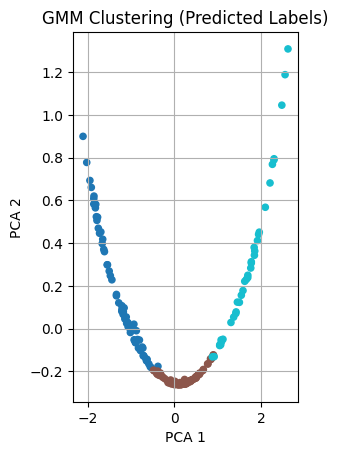

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, cmap='tab10', s=20)
plt.title("GMM Clustering (Predicted Labels)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

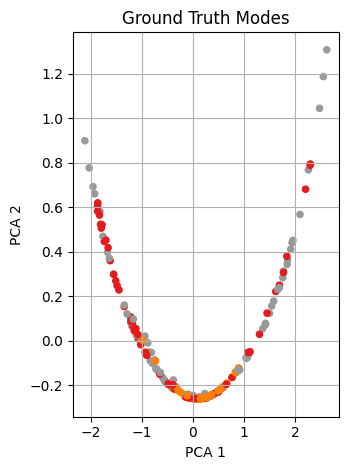

In [ ]:
plt.subplot(1, 2, 2)
plt.scatter(emb2d[:, 0], emb2d[:, 1], c=true_modes, cmap='Set1', s=20)
plt.title("Ground Truth Modes")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

plt.tight_layout()
plt.show()